# K-means clustering and PCA

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import scipy.io as io
import scipy.linalg as la
import imageio as imio
%matplotlib inline

## K-means clustering

In [2]:
# Load data.
data = io.loadmat(os.path.join('data','ex7data2.mat'))
X = data['X']

### K-means implementation

In [3]:
# Initialize centroids.
def initialize_centroids(x, k):
    """
    Here x is the data, and k is the number of centroids. 
    Selects k random points from the data as the centroids.
    """
    choice = np.random.randint(len(x), size=k)
    centroids = x[choice]
    return centroids

initial_centroids = initialize_centroids(X, 3)
print(initial_centroids)

[[3.12405123 0.67821757]
 [2.79995882 5.11526323]
 [6.00506534 2.72784171]]


In [4]:
# Find closest centroids.
def find_closest_centroids(x, centroids):
    """
    Takes a M x N data array, x, and a K x N centroid array, centroids. 
    Returns a M x 1 array of cluster indices. The i-th element of this
    array is the index of the centroid that the i-th data point is 
    closest too.
    """
    distances_from_centroids = np.sum(np.square(x[:, None] - centroids), axis=2)
    minimum_indices = np.argmin(distances_from_centroids, axis=1)
    return minimum_indices

closest_indices = find_closest_centroids(X, initial_centroids)
print(closest_indices[:3])

[1 2 2]


In [5]:
# Compute cluster means.
def compute_means(x, centroid_indices):
    """
    Takes a M x N data array, x, and a M x 1 array of centroid indices.
    Computes the means of the clusters corresponding to each centroid index.
    """
    number_of_clusters = len(np.unique(centroid_indices))
    cluster_means = np.zeros((number_of_clusters, x.shape[1]))
    for i in np.arange(number_of_clusters):
        cluster_means[i] = np.mean(x[centroid_indices==i], axis=0)
    return cluster_means

cluster_means = compute_means(X, closest_indices)
print(cluster_means)

[[3.03458254 0.9985308 ]
 [1.98363152 5.03043004]
 [6.02440317 2.97266054]]


In [6]:
# Combine the above functions to implement K-means.
def run_k_means(x, k, iters):
    centroids = initialize_centroids(x, k)
    indices = np.zeros(x.shape[0])
    centroid_history = [centroids]
    for i in np.arange(iters):
        indices = find_closest_centroids(x, centroids)
        centroids = compute_means(x, indices)
        centroid_history.append(centroids)
    return indices, centroid_history

closest_indices, centroid_history = run_k_means(X, 3, 10)

In [7]:
def plot_k_means(x, k, indices, centroid_history):
    fig = plt.figure(figsize=(10,6)) 
    
    # Plot clusters.
    for i in range(k):
        cluster = x[closest_indices==i]
        plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')
        
    # Plot centroid history.
    x1, x2 = [], []
    for centroids in centroid_history:
        x1.append(centroids[:, 0])
        x2.append(centroids[:, 1])
    for i in range(len(x1[0])):
        plt.plot(x1, x2, 'kx--', markersize=8)
        
    plt.legend(loc='upper right')

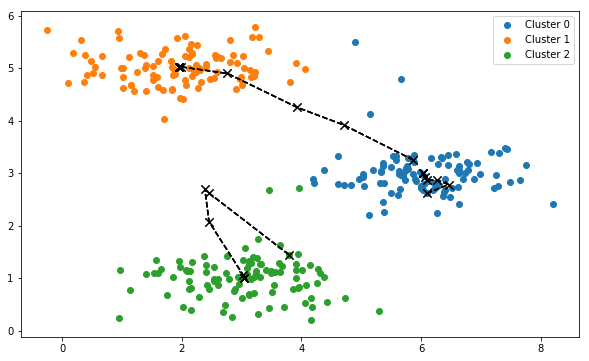

In [8]:
plot_k_means(X, 3, closest_indices, centroid_history)

### Image compression using K-means 

In [9]:
# Load data.
image = imio.imread(os.path.join('data', 'bird_small.png'))
image_dimensions = image.shape

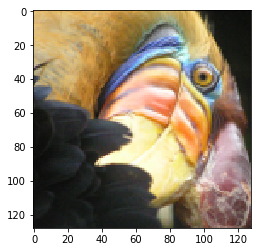

In [10]:
# Original image.
plt.imshow(image)

In [11]:
# Normalize the data.
image = image / 255

# Unroll the image in the RGB space.
image = image.reshape(-1, 3)

In [12]:
# Run K-means. 
num_clusters = 16
centroid_indices, centroid_history = run_k_means(image, num_clusters, 10)

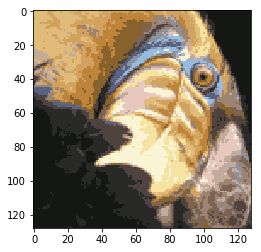

In [13]:
# Form the compressed image.
final_centroids = centroid_history[-1]
compressed_image = np.zeros((centroid_indices.shape[0], 3))
for i in range(centroid_indices.shape[0]):
    compressed_image[i] = final_centroids[centroid_indices[i]]
compressed_image = compressed_image.reshape(image_dimensions)
plt.imshow(compressed_image)

## Principal component analysis

In [14]:
# Load data.
data = io.loadmat(os.path.join('data','ex7data1.mat'))
X = data['X']

### PCA implementation 

In [15]:
# Feature normalize.
def feature_normalize(x):
    mean = np.mean(x, axis=0)
    std_deviation = np.std(x, axis=0)
    return (x - mean) / std_deviation, mean, std_deviation

normed_X, mean, std_deviation = feature_normalize(X)

In [16]:
# Covariance matrix and single value decomposition
def compute_covariance_matrix(x):
    m, n = x.shape
    covariance_matrix = np.dot(x.T, x)
    covariance_matrix = covariance_matrix / m
    return covariance_matrix

def get_usv(x):
    cov_matrix = compute_covariance_matrix(x)
    return la.svd(cov_matrix, full_matrices=True, compute_uv=True)

U, S, V = get_usv(normed_X)

In [17]:
print(f'Top principal component is {U[0]}.')

Top principal component is [-0.70710678 -0.70710678].


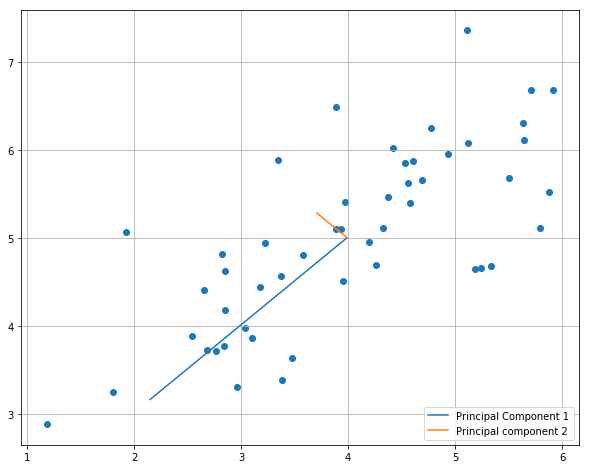

In [18]:
# Plot the two principal components.
fig = plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])
plt.grid(True)
# The principal components are drawn starting at the mean of the data.
# This is because the mean was subtracted from the data.
plt.plot([mean[0], mean[0] + 1.5 * S[0] * U[0, 0]],
         [mean[1], mean[1] + 1.5 * S[0] * U[0, 1]],
         label='Principal Component 1')
plt.plot([mean[0], mean[0] + 1.5 * S[1] * U[1, 0]],
         [mean[1], mean[1] + 1.5 * S[1] * U[1, 1]],
         label='Principal component 2')
plt.legend(loc='lower right')

### Dimensionality reduction with PCA

In [19]:
# Reduce the dimensions from n to k, i.e. project 
# the data along the first k principal components.

def project_data(x, u, k):
    """
    Here x is the data, u is the U matrix from the SVD, 
    and k is the dimensionality of the projected data.
    """
    reduced_u = u[:, :k]
    z = np.dot(x, reduced_u)
    return z

z = project_data(normed_X, U, 1)
print(f'Projection of the first example is {z[0][0]}.')

Projection of the first example is 1.4963126084578517.


In [20]:
# Recover an approximation of the original data 
# from the projected data.

def recover_data(z, u, k):
    """
    Here z is the projected data, u is the U matrix from
    the SVD of the original data, and k is the dimensionality
    of the features in z.
    """
    reduced_u = u[:, :k]
    x = np.dot(z, reduced_u.T)
    return x

rec_X = recover_data(z, U, 1)
print(f'Recovered approximation of the first example is {rec_X[0]}.')

Recovered approximation of the first example is [-1.05805279 -1.05805279].


Text(0.5, 1.0, 'PCA projections')

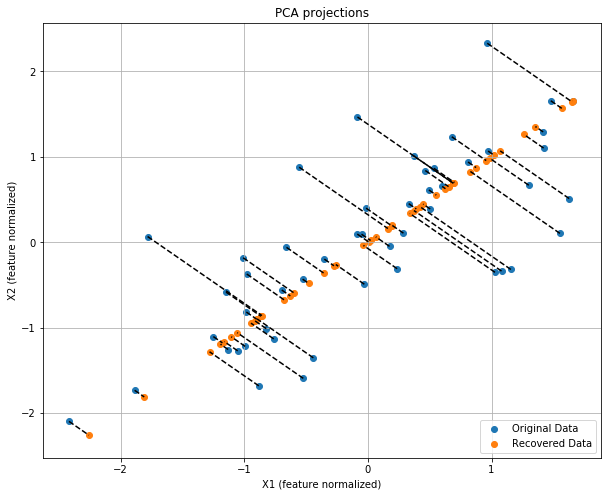

In [21]:
# Visualize projections.
fig = plt.figure(figsize=(10, 8))
plt.scatter(normed_X[:, 0], normed_X[:, 1], label='Original Data')
plt.scatter(rec_X[:, 0], rec_X[:, 1], label='Recovered Data')
plt.grid(True)
plt.legend(loc='lower right')
for i in range(normed_X.shape[0]):
    plt.plot([normed_X[i, 0], rec_X[i, 0]], 
             [normed_X[i, 1], rec_X[i, 1]], 'k--')
plt.xlabel('X1 (feature normalized)')
plt.ylabel('X2 (feature normalized)')
plt.title('PCA projections')

Thus the projection only preserves the information along the principal component.

### PCA with images

In [22]:
# Load data.
data = io.loadmat(os.path.join('data', 'ex7faces.mat'))
X = data['X']

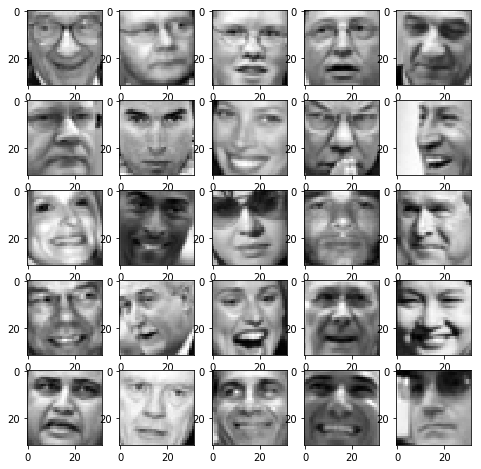

In [23]:
# Visualize data.
def plot_faces(x, nrows=10, ncols=10):
    width, height = 32, 32
    fig, ax = plt.subplots(nrows, ncols, figsize=(8, 8))
    irow, icol = 0, 0
    for i in range(nrows * ncols):
        if icol == ncols:
            irow += 1
            icol = 0
        ax[irow, icol].imshow(x[i, :].reshape(width, height).T, cmap='gray')
        icol += 1
    
plot_faces(X, 5, 5)

In [24]:
# Feature Normalize.
normed_X, mean, std_deviation = feature_normalize(X)

# SVD.
U, S, V = get_usv(normed_X)

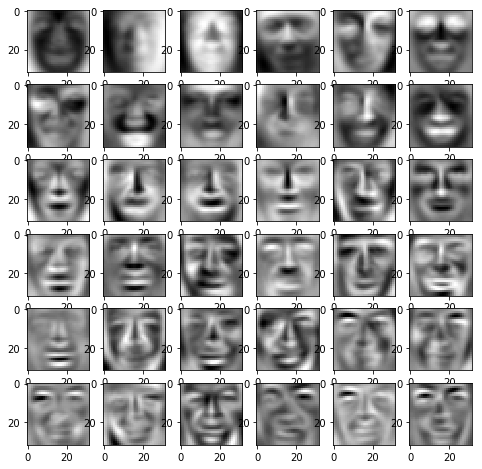

In [25]:
# Visualize the first 36 principal components.
reduced_U = U[:, :36].T
plot_faces(reduced_U, 6, 6)

In [26]:
# Project the data on the first 100 principal components.
z = project_data(normed_X, U, 100)

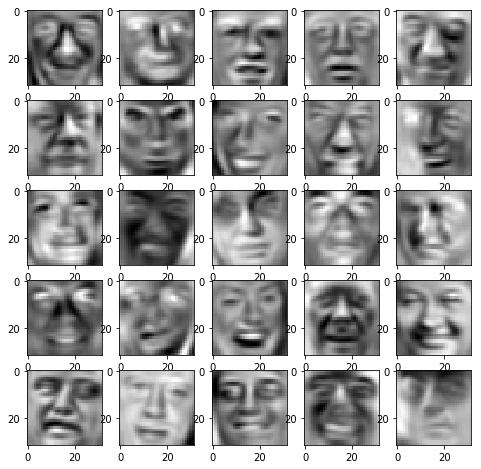

In [27]:
# Recover data from projection.
rec_X = recover_data(z, U, 100)
plot_faces(rec_X, 5, 5)

The projection loses the fine details of the images but preserves the general structure and appearance, which can be used by a learning process.

#### PCA with RGB data

In [28]:
# PCA with bird's picture. Going from 3D (RGB) space to 2D.
normed_image, image_mean, image_std_deviation = feature_normalize(image)
U, S, V = get_usv(normed_image)
z = project_data(normed_image, U, 2)
rec_image = recover_data(z, U, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


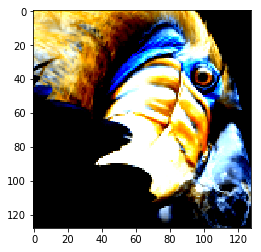

In [29]:
plt.imshow(rec_image.reshape(image_dimensions))

**K-means with PCA**

<IPython.core.display.Javascript object>


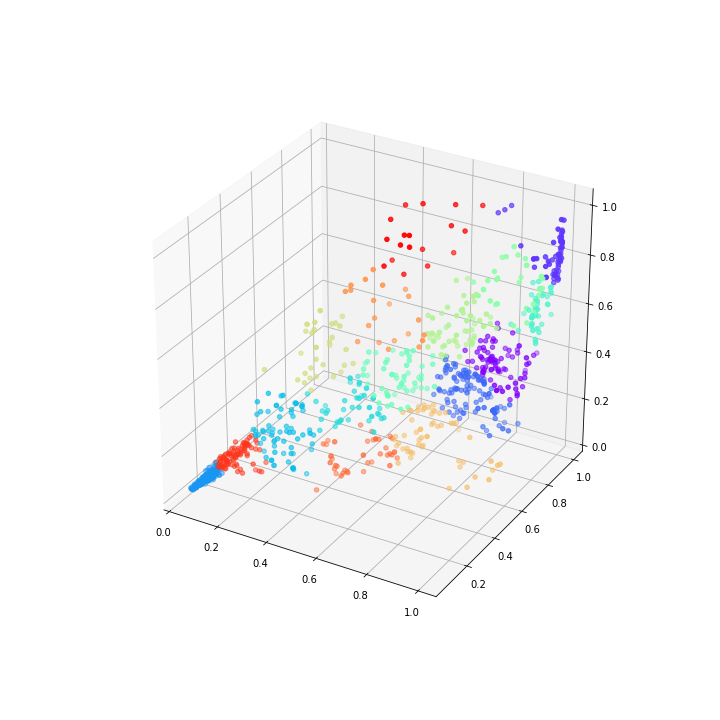

In [56]:
# K-means of original 3D image.
%matplotlib notebook
%matplotlib notebook

sel = np.random.randint(len(image), size=1000)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.scatter3D(image[sel, 0], image[sel, 1], image[sel, 2], cmap='rainbow', c=centroid_indices[sel])

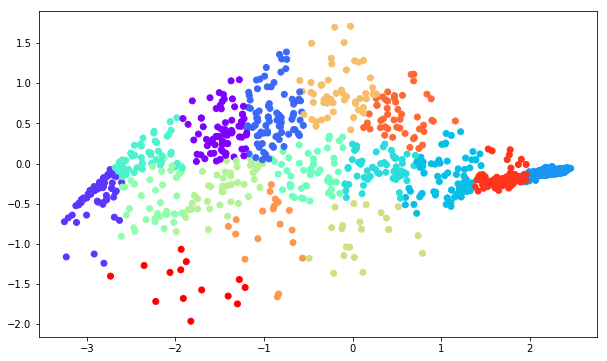

In [53]:
# Plot projection
%matplotlib inline

fig = plt.figure(figsize=(10, 6))
plt.scatter(z[sel, 0], z[sel, 1], cmap='rainbow', c=centroid_indices[sel])